In [1]:
%load_ext autoreload
%autoreload 2

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sys
import jax.scipy as jsp

### Data

In [3]:
import matplotlib.pyplot as plt

In [4]:
from utils.dataset import get_dataset_by_name
# Data, modelling and hyperparameters setup


In [5]:
class LossHistory(object):
    
    def __init__(self, name):
        self.name = name
        self.crm_loss = []
        self.online_loss = []
        self.betas = []
        self.n_samples = []
        self.n_actions = []
        self.cumulated_loss = []
        self.regret = []
        
    def update(self, beta, online_loss, regret, crm_loss, cumulated_losses, n_samples):
        self.betas += [beta]
        self.online_loss += [online_loss]
        self.crm_loss += [crm_loss]
        self.n_samples += [n_samples]
        self.cumulated_loss += [np.sum(self.cumulated_loss) + cumulated_losses]
        self.regret += [np.sum(self.regret) + regret*n_samples] 
        
    def show_last(self):
        print(
            '<', self.name,
            'CRM loss: %.5f' % self.crm_loss[-1],
            'Online loss: %.5f' % self.online_loss[-1],
            '|beta|=%.2f' % np.sqrt((self.betas[-1]**2).sum()), 
            'n=%d' % sum(self.n_samples),
            '>',
            file=sys.stderr
        )
    



In [77]:
class Model():
    
    def __init__(self, name, random_seed):
        self.name = name
        self.rng = np.random.RandomState(random_seed)
    
    def create_start_parameter(self, dataset):
        d = dataset.dimension
#         parameter_scale = dataset.parameter_scale
        parameter_scale = 0.1
        
        if self.name == 'linear':
#             return self.rng.normal(scale=0.1, size=d + 2)
            return np.concatenate([np.array([30.]), self.rng.normal(scale=parameter_scale, size=d)])
#             return theta

        elif self.name == 'polynomial':
            return np.concatenate([np.array([1]), self.rng.normal(scale=parameter_scale, size=d ** 2 + d)])
        else:
            return

    def _linear_modelling(self, parameter, features):
#         intercept_coeff, mean_coeff, var = parameter[0], parameter[1:-1], parameter[-1]
        intercept_coeff, mean_coeff = parameter[0], parameter[1:]
        predictions = jnp.dot(features, mean_coeff) + intercept_coeff
#         predictions = jnp.clip(predictions, 0, 1000)
#         predictions = 50*jsp.special.expit(predictions)
        return predictions
    
    def _polynomial_modelling(self, parameter, features):
        n = features.shape[1]
#         intercept, coeff_lin, coeff_kern, var = parameter[0], parameter[1:n + 1], parameter[n + 1:-1], parameter[-1]
        intercept, coeff_lin, coeff_kern = parameter[0], parameter[1:n + 1], parameter[n + 1:]
    
        m_linear = jnp.dot(features, coeff_lin) + intercept
        f = jnp.einsum('ij,ih->ijh', features, features).reshape(features.shape[0], -1)
        m_kern = jnp.dot(f, coeff_kern)
        mean = m_kern + m_linear
        return mean
    
    def get_parameter(self, parameter, features):
        if self.name == 'linear':
            return self._linear_modelling(parameter, features)
        elif self.name == 'polynomial':
            return self._polynomial_modelling(parameter, features)
        else:
            return  

        

In [37]:
# actions, contexts, losses, propensities, potentials = dataset.get_logged_data()

# from sklearn.linear_model import LogisticRegression, RidgeCV

# pistar_determinist = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])

# pistar_determinist.fit(contexts, potentials)
# theta = np.concatenate([np.array([pistar_determinist.intercept_]), pistar_determinist.coef_])

# theta

In [38]:
# contextual_modelling = Model(settings['contextual_modelling'], random_seed)

# for _ in range(10):
#     eps = np.random.normal(0, 1, theta.shape[0])
#     contextual_param = contextual_modelling.get_parameter(theta+eps, contexts)
#     importance_weights = pdf(contextual_param, actions)/propensities
#     print('offline', np.mean(losses * importance_weights))
#     sampled_actions = np.random.normal(contextual_param, logging_scale, contexts.shape[0])
    
#     print('online', np.mean(dataset.get_losses_from_actions(potentials, sampled_actions)))

In [106]:
import jax
import jax.numpy as jnp
import jaxopt

logging_scale = 1

def pdf(loc, x):
    scale = logging_scale
    return 1/(scale * jnp.sqrt(2*jnp.pi)) * jnp.exp(-((x - loc)/scale)**2/2)

class Estimator():
    def __init__(self, contextual_modelling, mode='conservative', lbd=0.1):
        self.contextual_modelling = contextual_modelling
        self.mode = mode
        bonus = 1 if self.mode == 'conservative' else -1
        self.lbd = bonus * lbd
        
    def objective_function(self, param, actions, contexts, losses, propensities):
        
        contextual_param = self.contextual_modelling.get_parameter(param, contexts)
#         propensities = jnp.clip(propensities, 1e-5, None)
        importance_weights = pdf(contextual_param, actions)/propensities 
        importance_weights = jnp.clip(importance_weights, 1e-5, 1e3)
        mean = jnp.sum(losses * importance_weights)/jnp.sum(importance_weights)
        std = jnp.std(losses * importance_weights)
        lambda2 = .0
        norm_parameter = jnp.linalg.norm(param[1:])
        return mean + self.lbd * std + lambda2 * norm_parameter
    
    
def optimize(loss_fun, init_parameter, args):
    
#     import ipdb; ipdb.set_trace()
    lbfgsb = jaxopt.ScipyMinimize(fun=loss_fun, method="Newton-CG").run(init_parameter, *args)
#     import ipdb; ipdb.set_trace()
#     print(lbfgsb)
    lbfgs_sol = lbfgsb.params
    lbfgs_fun_val = lbfgsb.state.fun_val
    
    return lbfgs_sol, lbfgs_fun_val

# Experiment

In [107]:
def get_logging_data(n_samples, dataset):

    start = 0
    end = n_samples
    
    actions = dataset.actions_train[start:end]
    contexts = dataset.features_train[start:end, :]
    losses = dataset.losses_train[start:end]
    propensities = dataset.propensities_train[start:end]

    logging_data = actions, contexts, losses, propensities
    return logging_data

def sample_data(n_samples, index, dataset):

    start = n_samples * index
    end = start + n_samples
    
    contexts = dataset.features_train[start:end, :]
    potentials = dataset.potentials_train[start:end]

    return contexts, potentials

def update_past_data(data, samples):
    return np.hstack([data, samples])

In [108]:
import os


def online_evaluation(optimized_param, contextual_modelling, dataset, random_seed):
    
    rng = np.random.RandomState(random_seed)
    contexts, potentials = dataset.test_data
    contextual_param = contextual_modelling.get_parameter(optimized_param, contexts)
    size = contexts.shape[0]
    losses = []
    
    for i in range(10):
        sampled_actions = rng.normal(contextual_param, logging_scale, size)
        losses += [dataset.get_angela_losses_from_actions(potentials, sampled_actions)]
        
    losses_array = np.stack(losses, axis=0)
    var_pi = np.mean(np.var(losses_array, axis=0))
    var_context = np.var(np.mean(losses_array, axis=1))
    return np.mean(losses_array), np.std(np.mean(losses_array, axis=0))
    
def start_experiment(random_seed, dataset, name):
    print(
        '***', 'EXPERIMENT', name,
        'Random seed: %i' % random_seed,
        'Dataset: %s' % dataset.name,
        '***',
        file=sys.stderr
    )

In [109]:
M = 10

In [91]:
dataset_name = 'warfarin'
settings = {
    'lambda': 0.001,
    'contextual_modelling': 'linear'
}

dataset = get_dataset_by_name(dataset_name)

reducing dimension for Warfarin dataset


/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


In [92]:
T = dataset.actions_train.shape[0]
T

2666

In [93]:
dataset.actions_train.mean()

32.690155460175504

In [94]:
dataset.actions_test.shape

(1314,)

### Same sampling design - CRM

In [110]:
betas = []



# actions, features, losses, propensities, potentials = dataset.sample_logged_data(n_samples=1000)

crm_histories = []

# optimal_mu = dataset.get_optimal_parameter(settings['contextual_modelling'])


def crm_experiment(random_seed, dataset_name, settings):
    
    dataset = get_dataset_by_name(dataset_name, random_seed)

    start_experiment(random_seed, dataset, 'CRM')
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = Estimator(contextual_modelling, 'conservative', settings['lambda'])
    crm_loss_history = LossHistory("CRM")
    
    
    # optimal_loss, _ = online_evaluation(optimal_mu, contextual_modelling, dataset, random_seed)


    
    n_samples = T // M
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    init_parameter = jnp.array(mu, dtype='float32')
    logging_data = get_logging_data(n_samples, dataset)
    rng = np.random.RandomState(random_seed)
    
    actions, contexts, losses, propensities = logging_data
#     scaler = preprocessing.MinMaxScaler().fit(contexts)
#     contexts = scaler.transform(contexts)

    for m in range(M):

        # Optimization 
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        

        ### New logging data
        loss_crm = loss_crm._value
        
        sampled_contexts, sampled_potentials = sample_data(n_samples, m, dataset)
        contextual_param = contextual_modelling.get_parameter(mu, sampled_contexts)
        sampled_actions = rng.normal(contextual_param, logging_scale, n_samples)
#         import ipdb; ipdb.set_trace()
        sampled_losses = dataset.get_losses_from_actions(sampled_potentials, sampled_actions)
        sampled_propensities = norm(loc=contextual_param, scale=logging_scale).pdf(sampled_actions)
        
        cumulated_losses = np.sum(sampled_losses)
        
        actions = update_past_data(actions, sampled_actions)
        contexts = np.vstack([contexts, sampled_contexts])
#         scaler = preprocessing.MinMaxScaler().fit(contexts)
#         contexts = scaler.transform(contexts)
        losses = update_past_data(losses, sampled_losses)
        propensities = update_past_data(propensities, sampled_propensities)
        
        logging_data = actions, contexts, losses, propensities

        ## Record 
        online_loss, _ = online_evaluation(optimized_mu._value, contextual_modelling, dataset, random_seed)
        # regret = online_loss - optimal_loss
        regret = 0
    
        crm_loss_history.update(optimized_mu, online_loss, regret, loss_crm, cumulated_losses, n_samples)
        crm_loss_history.show_last()
        
    return crm_loss_history


for random_seed in range(5):
    crm_loss_history = crm_experiment(random_seed, dataset_name, settings)
    crm_histories.append(crm_loss_history)


crm_losses = np.array([crm_loss_history.crm_loss for crm_loss_history in crm_histories])
mean_crm_losses = np.mean(crm_losses, axis=0)

crm_online_losses = np.array([crm_loss_history.online_loss for crm_loss_history in crm_histories])
mean_crm_online_losses = np.mean(crm_online_losses, axis=0)

crm_cumulated_losses = np.array([crm_loss_history.cumulated_loss for crm_loss_history in crm_histories])
mean_crm_cumulated_losses = np.nanmean(crm_cumulated_losses, axis=0)

crm_regrets = np.array([crm_loss_history.regret for crm_loss_history in crm_histories])
mean_crm_regrets = np.nanmean(crm_regrets, axis=0)

reducing dimension for Warfarin dataset


/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
*** EXPERIMENT CRM Random seed: 0 Dataset: warfarin ***
< CRM CRM loss: 11.33712 Online loss: 9.27510 |beta|=29.97 n=266 >
< CRM CRM loss: 12.07539 Online loss: 9.36887 |beta|=29.99 n=532 >
< CRM CRM loss: 8.26893 Online loss: 9.56245 |beta|=29.78 n=798 >
< CRM CRM loss: 7.06163 Online loss: 9.52612 |beta|=29.66 n=1064 >
< C

reducing dimension for Warfarin dataset


< CRM CRM loss: 9.29655 Online loss: 9.40928 |beta|=30.22 n=266 >
< CRM CRM loss: 10.95025 Online loss: 29.74178 |beta|=45.34 n=532 >
< CRM CRM loss: 4.68935 Online loss: 661.61645 |beta|=966.08 n=798 >
< CRM CRM loss: 28.44228 Online loss: 9.80578 |beta|=30.01 n=1064 >
< CRM CRM loss: 17.52626 Online loss: 9.82940 |beta|=29.98 n=1330 >
< CRM CRM loss: 23.11283 Online loss: 9.73221 |beta|=29.94 n=1596 >
< CRM CRM loss: 29.85205 Online loss: 9.80578 |beta|=30.01 n=1862 >
< CRM CRM loss: 15.44177 Online loss: 13.09945 |beta|=31.25 n=2128 >
< CRM CRM loss: 15.38752 Online loss: 14.56689 |beta|=33.64 n=2394 >
< CRM CRM loss: 33.41098 Online loss: 9.80578 |beta|=30.01 n=2660 >
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html

reducing dimension for Warfarin dataset


< CRM CRM loss: 6.91785 Online loss: 9.41287 |beta|=29.96 n=266 >
< CRM CRM loss: 22.53108 Online loss: 9.94479 |beta|=30.20 n=532 >
< CRM CRM loss: 17.18123 Online loss: 8.74407 |beta|=30.05 n=798 >
< CRM CRM loss: 16.86028 Online loss: 9.14996 |beta|=30.18 n=1064 >
< CRM CRM loss: 22.40179 Online loss: 8.93124 |beta|=30.10 n=1330 >
< CRM CRM loss: 15.27122 Online loss: 8.93828 |beta|=30.18 n=1596 >
< CRM CRM loss: 23.86022 Online loss: 8.85309 |beta|=30.07 n=1862 >
< CRM CRM loss: 14.23524 Online loss: 10.22009 |beta|=30.47 n=2128 >
< CRM CRM loss: 19.81217 Online loss: 8.66957 |beta|=29.99 n=2394 >
< CRM CRM loss: 20.03448 Online loss: 9.03285 |beta|=30.45 n=2660 >
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  w

reducing dimension for Warfarin dataset


< CRM CRM loss: 5.58722 Online loss: 9.53523 |beta|=30.13 n=266 >
< CRM CRM loss: 15.19193 Online loss: 9.53093 |beta|=30.28 n=532 >
< CRM CRM loss: 16.33091 Online loss: 9.93799 |beta|=30.38 n=798 >
< CRM CRM loss: 13.47028 Online loss: 9.52094 |beta|=30.06 n=1064 >
< CRM CRM loss: 15.33502 Online loss: 9.30250 |beta|=30.11 n=1330 >
< CRM CRM loss: 17.92686 Online loss: 9.31409 |beta|=30.12 n=1596 >
< CRM CRM loss: 7.76110 Online loss: 9.64729 |beta|=30.31 n=1862 >
< CRM CRM loss: 21.11670 Online loss: 9.42284 |beta|=30.11 n=2128 >
< CRM CRM loss: 21.63810 Online loss: 9.46533 |beta|=30.12 n=2394 >
< CRM CRM loss: 11.81626 Online loss: 8.92967 |beta|=30.22 n=2660 >
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  war

reducing dimension for Warfarin dataset


< CRM CRM loss: 9.71190 Online loss: 8.69954 |beta|=30.03 n=266 >
< CRM CRM loss: 19.12226 Online loss: 8.92818 |beta|=30.06 n=532 >
< CRM CRM loss: 26.53009 Online loss: 8.78840 |beta|=30.03 n=798 >
< CRM CRM loss: 23.75032 Online loss: 8.64897 |beta|=29.96 n=1064 >
< CRM CRM loss: 19.43151 Online loss: 8.78948 |beta|=30.21 n=1330 >
< CRM CRM loss: 16.36499 Online loss: 8.64066 |beta|=30.23 n=1596 >
< CRM CRM loss: 21.94771 Online loss: 8.72130 |beta|=30.18 n=1862 >
< CRM CRM loss: 5.24667 Online loss: 103.37286 |beta|=52.74 n=2128 >
< CRM CRM loss: 9.38849 Online loss: 9.28166 |beta|=30.64 n=2394 >
< CRM CRM loss: 18.62168 Online loss: 11.39119 |beta|=30.58 n=2660 >


### Sequential CRM - Myopic

In [130]:
# scrm_m_histories = []

# settings = {
#     'lambda': 0.01,
#     'contextual_modelling': 'linear'
# }


# def scrm_myopic_experiment(random_seed, dataset_name, settings):
    
#     dataset = get_dataset_by_name(dataset_name, random_seed)
#     start_experiment(random_seed, dataset, 'SCRM Myopic')
    
#     # Model setting
#     contextual_modelling = Model(settings['contextual_modelling'], random_seed)
#     estimator = Estimator(contextual_modelling, 'conservative', settings['lambda'])
#     scrm_m_loss_history = LossHistory("SCRM-M")

#     n_samples = T // M
# #     optimal_loss, _ = online_evaluation(optimal_mu, contextual_modelling, dataset, random_seed)
    
#     # Logging data
#     mu = contextual_modelling.create_start_parameter(dataset)
#     logging_data = get_logging_data(n_samples, dataset)
#     rng = np.random.RandomState(random_seed)
    
#     for m in range(M):

#         # Optimization 
#         init_parameter = jnp.array(mu, dtype='float32')
#         args = logging_data
#         optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        

#         ### New logging data
#         mu = optimized_mu._value
#         loss_crm = loss_crm._value
        
#         contexts, potentials = sample_data(n_samples, m, dataset)
#         contextual_param = contextual_modelling.get_parameter(mu, contexts)
#         actions = rng.normal(contextual_param, logging_scale, n_samples)
#         losses = dataset.get_losses_from_actions(potentials, actions)
#         propensities = norm(loc=contextual_param, scale=logging_scale).pdf(actions)
#         logging_data = actions, contexts, losses, propensities

#         ## Record 
#         online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
# #         regret = online_loss - optimal_loss
#         regret = 0
#         cumulated_losses = np.sum(losses)
        
#         scrm_m_loss_history.update(optimized_mu, online_loss, regret, loss_crm, cumulated_losses, n_samples)
#         scrm_m_loss_history.show_last()
    
#     return scrm_m_loss_history

# for random_seed in range(5):
#     scrm_m_loss_history = scrm_myopic_experiment(random_seed, dataset_name, settings)
#     scrm_m_histories.append(scrm_m_loss_history)

# scrm_m_losses = np.array([scrm_m_loss_history.crm_loss for scrm_m_loss_history in scrm_m_histories])
# mean_scrm_m_losses = np.mean(scrm_m_losses, axis=0)

# scrm_m_online_losses = np.array([scrm_m_loss_history.online_loss for scrm_m_loss_history in scrm_m_histories])
# mean_scrm_m_online_losses = np.mean(scrm_m_online_losses, axis=0)

# scrm_m_cumulated_losses = np.array([scrm_m_loss_history.cumulated_loss for scrm_m_loss_history in scrm_m_histories])
# mean_scrm_m_cumulated_losses = np.nanmean(scrm_m_cumulated_losses, axis=0)

# scrm_m_regrets = np.array([scrm_m_loss_history.regret for scrm_m_loss_history in scrm_m_histories])
# mean_scrm_m_regrets = np.nanmean(scrm_m_regrets, axis=0)

*** EXPERIMENT SCRM Myopic Random seed: 0 Dataset: warfarin ***
< SCRM-M CRM loss: 44.80391 Online loss: 26.42633 |beta|=3.00 n=264 >
< SCRM-M CRM loss: 3.95186 Online loss: 31.63879 |beta|=4.71 n=528 >
< SCRM-M CRM loss: 32.96450 Online loss: 31.63879 |beta|=4.71 n=792 >
< SCRM-M CRM loss: 34.14581 Online loss: 31.63879 |beta|=4.71 n=1056 >
< SCRM-M CRM loss: 34.90332 Online loss: 31.63879 |beta|=4.71 n=1320 >
< SCRM-M CRM loss: 0.00000 Online loss: 21.81705 |beta|=7.38 n=1584 >
< SCRM-M CRM loss: 22.88211 Online loss: 21.81705 |beta|=7.38 n=1848 >
< SCRM-M CRM loss: 20.71470 Online loss: 21.81705 |beta|=7.38 n=2112 >
< SCRM-M CRM loss: 20.69583 Online loss: 21.81705 |beta|=7.38 n=2376 >
< SCRM-M CRM loss: 23.00777 Online loss: 21.81705 |beta|=7.38 n=2640 >
*** EXPERIMENT SCRM Myopic Random seed: 1 Dataset: warfarin ***
< SCRM-M CRM loss: 25.18871 Online loss: 26.84751 |beta|=3.00 n=264 >
< SCRM-M CRM loss: 34.92263 Online loss: 26.84751 |beta|=3.00 n=528 >
< SCRM-M CRM loss: 34.72805

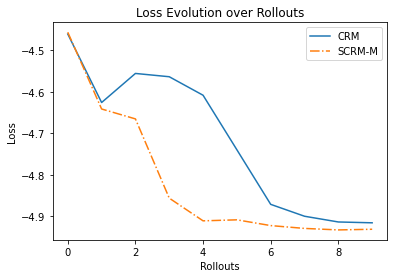

In [53]:
plt.figure()
plt.title('Loss Evolution over Rollouts')
plt.xlabel('Rollouts')
plt.plot(mean_crm_online_losses, '-', label='CRM')
plt.plot(mean_scrm_m_online_losses, '-.', label='SCRM-M')
plt.ylabel('Loss')
plt.legend(loc='upper right')



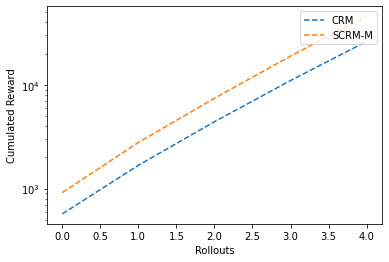

In [47]:
plt.xlabel('Rollouts')
plt.ylabel('Cumulated Reward')
plt.plot(-mean_crm_cumulated_losses, '--', label='CRM')
plt.plot(-mean_scrm_m_cumulated_losses, '--', label='SCRM-M')
plt.legend(loc='upper right')
plt.yscale('log')

## Sequential with past information

### Naive Multi IPS

In [19]:
### Utilities

def get_all_data(logging_actions, logging_contexts, logging_losses, logging_propensities):
    all_logging_actions = np.concatenate(logging_actions)
    all_logging_contexts = np.concatenate(logging_contexts)
    all_logging_losses = np.concatenate(logging_losses)
    all_logging_propensities = np.concatenate(logging_propensities)
    return all_logging_actions, all_logging_contexts, all_logging_losses, all_logging_propensities

def update_past_data(data, samples):
    return np.hstack([data, samples])

In [111]:
scrm_nmips_histories = []

def scrm_nmips_experiment(random_seed, dataset_name, settings):

    dataset = get_dataset_by_name(dataset_name, random_seed)
    start_experiment(random_seed, dataset, 'Naive MultiIPS SCRM')
    
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = Estimator(contextual_modelling, 'conservative', settings['lambda'])
    scrm_nmips_loss_history = LossHistory("SCRM-NMIPS")
    
    n_samples = T // M
#     optimal_loss, _ = online_evaluation(optimal_mu, contextual_modelling, dataset, random_seed)
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    logging_data = get_logging_data(n_samples, dataset)
    rng = np.random.RandomState(random_seed)
    
    # Setting
    all_actions, all_contexts, all_losses, all_propensities = logging_data
    
    for m in range(M):

        ### Logging data with mixture propensities
        logging_data = all_actions, all_contexts, all_losses, all_propensities

        # Optimization 
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        
        
        ### New logging data
        mu = optimized_mu._value
        loss_crm = loss_crm._value
        
        contexts, potentials = sample_data(n_samples, m, dataset)
        contextual_param = contextual_modelling.get_parameter(mu, contexts)
        actions = rng.normal(contextual_param, logging_scale, n_samples)
        losses = dataset.get_losses_from_actions(potentials, actions)
        propensities = norm(loc=contextual_param, scale=logging_scale).pdf(actions)
        logging_data = actions, contexts, losses, propensities
        
        ## Record 
        online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
#         regret = online_loss - optimal_loss
        regret = 0
        cumulated_losses = np.sum(losses)
        scrm_nmips_loss_history.update(optimized_mu, online_loss, regret, loss_crm, cumulated_losses, n_samples)
        scrm_nmips_loss_history.show_last()
        
        all_actions = update_past_data(all_actions, actions)
        all_contexts = np.vstack([all_contexts, contexts])
        all_losses = update_past_data(all_losses, losses)
        all_propensities = update_past_data(all_propensities, propensities)
        
    return scrm_nmips_loss_history

for random_seed in range(5):
    scrm_nmips_loss_history = scrm_nmips_experiment(random_seed, dataset_name, settings)
    scrm_nmips_histories.append(scrm_nmips_loss_history)

scrm_nmips_losses = np.array([scrm_nmips_loss_history.crm_loss for scrm_nmips_loss_history in scrm_nmips_histories])
mean_scrm_nmips_losses = np.nanmean(scrm_nmips_losses, axis=0)

scrm_nmips_online_losses = np.array([scrm_nmips_loss_history.online_loss for scrm_nmips_loss_history in scrm_nmips_histories])
mean_scrm_nmips_online_losses = np.nanmean(scrm_nmips_online_losses, axis=0)

scrm_nmips_cumulated_losses = np.array([scrm_nmips_loss_history.cumulated_loss for scrm_nmips_loss_history in scrm_nmips_histories])
mean_scrm_nmips_cumulated_losses = np.nanmean(scrm_nmips_cumulated_losses, axis=0)

scrm_nmips_regrets = np.array([scrm_nmips_loss_history.regret for scrm_nmips_loss_history in scrm_nmips_histories])
mean_scrm_nmips_regrets = np.nanmean(scrm_nmips_regrets, axis=0)

reducing dimension for Warfarin dataset


/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
*** EXPERIMENT Naive MultiIPS SCRM Random seed: 0 Dataset: warfarin ***
< SCRM-NMIPS CRM loss: 11.33712 Online loss: 9.27510 |beta|=29.97 n=266 >
< SCRM-NMIPS CRM loss: 14.12268 Online loss: 9.17236 |beta|=29.98 n=532 >
< SCRM-NMIPS CRM loss: 13.35200 Online loss: 8.73680 |beta|=30.20 n=798 >
< SCRM-NMIPS CRM loss: 13.32928 

reducing dimension for Warfarin dataset


/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
*** EXPERIMENT Naive MultiIPS SCRM Random seed: 1 Dataset: warfarin ***
< SCRM-NMIPS CRM loss: 9.29655 Online loss: 9.40928 |beta|=30.22 n=266 >
< SCRM-NMIPS CRM loss: 9.86213 Online loss: 9.37512 |beta|=30.31 n=532 >
< SCRM-NMIPS CRM loss: 15.80586 Online loss: 9.42236 |beta|=30.28 n=798 >
< SCRM-NMIPS CRM loss: 16.55071 Online loss: 9.37053 |beta|=30.24 n=1064 >
< SCRM-NMIPS CRM loss: 19.28734 Online loss: 9.49885 |beta|=30.26 n=1330 >
< SCRM-NMIPS CRM loss: 21.18886 Online loss: 9.49885 |beta|=30.26 n=1596 >
< SCRM-NMIPS CRM loss: 17.36455 Online loss: 9.58945 |beta|=30.32 n=1862 >
< SCRM-NMIPS CRM loss: 19.24075 Online loss: 9.58945 |beta|=30.32 n=212

reducing dimension for Warfarin dataset


< SCRM-NMIPS CRM loss: 6.91785 Online loss: 9.41287 |beta|=29.96 n=266 >
< SCRM-NMIPS CRM loss: 20.89751 Online loss: 9.25252 |beta|=29.97 n=532 >
< SCRM-NMIPS CRM loss: 11.21895 Online loss: 25.81893 |beta|=45.23 n=798 >
< SCRM-NMIPS CRM loss: 26.20150 Online loss: 22.43326 |beta|=44.23 n=1064 >
< SCRM-NMIPS CRM loss: 45.85739 Online loss: 21.08411 |beta|=43.60 n=1330 >
< SCRM-NMIPS CRM loss: 50.22575 Online loss: 21.22166 |beta|=43.53 n=1596 >
< SCRM-NMIPS CRM loss: 39.72583 Online loss: 19.90266 |beta|=42.85 n=1862 >
< SCRM-NMIPS CRM loss: 24.34296 Online loss: 3492.25314 |beta|=3903.66 n=2128 >
< SCRM-NMIPS CRM loss: 1179252.87500 Online loss: 3492.00099 |beta|=3903.77 n=2394 >
< SCRM-NMIPS CRM loss: 103291.46094 Online loss: 3490.27829 |beta|=3903.37 n=2660 >
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray

reducing dimension for Warfarin dataset


< SCRM-NMIPS CRM loss: 5.58722 Online loss: 9.53523 |beta|=30.13 n=266 >
< SCRM-NMIPS CRM loss: 18.80858 Online loss: 9.36104 |beta|=30.16 n=532 >
< SCRM-NMIPS CRM loss: 18.21705 Online loss: 9.24526 |beta|=30.22 n=798 >
< SCRM-NMIPS CRM loss: 20.74650 Online loss: 9.24099 |beta|=30.21 n=1064 >
< SCRM-NMIPS CRM loss: 20.72645 Online loss: 9.24099 |beta|=30.21 n=1330 >
< SCRM-NMIPS CRM loss: 17.08500 Online loss: 8.94595 |beta|=30.22 n=1596 >
< SCRM-NMIPS CRM loss: 16.73451 Online loss: 44.65065 |beta|=60.79 n=1862 >
< SCRM-NMIPS CRM loss: 107.80882 Online loss: 42.29409 |beta|=60.18 n=2128 >
< SCRM-NMIPS CRM loss: 19.10063 Online loss: 45.19327 |beta|=55.88 n=2394 >
< SCRM-NMIPS CRM loss: 28.81865 Online loss: 40.48658 |beta|=55.99 n=2660 >
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information s

reducing dimension for Warfarin dataset


< SCRM-NMIPS CRM loss: 9.71190 Online loss: 8.69954 |beta|=30.03 n=266 >
< SCRM-NMIPS CRM loss: 14.61955 Online loss: 9.07213 |beta|=30.08 n=532 >
< SCRM-NMIPS CRM loss: 23.03501 Online loss: 9.07213 |beta|=30.08 n=798 >
< SCRM-NMIPS CRM loss: 18.25466 Online loss: 8.64856 |beta|=29.95 n=1064 >
< SCRM-NMIPS CRM loss: 20.82140 Online loss: 8.69397 |beta|=30.13 n=1330 >
< SCRM-NMIPS CRM loss: 19.90222 Online loss: 8.55359 |beta|=30.13 n=1596 >
< SCRM-NMIPS CRM loss: 21.70131 Online loss: 8.53265 |beta|=30.12 n=1862 >
< SCRM-NMIPS CRM loss: 23.32621 Online loss: 8.53265 |beta|=30.12 n=2128 >
< SCRM-NMIPS CRM loss: 21.97910 Online loss: 8.45719 |beta|=30.13 n=2394 >
< SCRM-NMIPS CRM loss: 22.52490 Online loss: 8.45719 |beta|=30.13 n=2660 >


### Multi data 

In [103]:
class MixtureEstimator():
    def __init__(self, contextual_modelling, mode='conservative', lbd=0.1):
        self.contextual_modelling = contextual_modelling
        self.mode = mode
        bonus = 1 if self.mode == 'conservative' else -1
        self.lbd = bonus * lbd
        self.params = []
        self.rollouts_n_samples = []
        
    def get_mixture_logging_propensities(self, all_policy_samples, all_contexts):
        distributions = []

        for param in self.params:
            contextual_param = self.contextual_modelling.get_parameter(param, all_contexts)
            distributions.append(norm(loc=contextual_param, scale=logging_scale).pdf)
        pi_t = np.array([distribution(all_policy_samples) for distribution in distributions])
        alpha_t = self.rollouts_n_samples/ np.sum(self.rollouts_n_samples)
        mixture_logging_propensities = np.sum(alpha_t * pi_t, axis=0)
        return mixture_logging_propensities
        
    def objective_function(self, param, actions, contexts, losses, mixture_propensities):
        contextual_param = self.contextual_modelling.get_parameter(param, contexts)
        mixture_propensities = jnp.clip(mixture_propensities, 1e-5, None)
        mixture_importance_weights = pdf(contextual_param, actions)/mixture_propensities
        mixture_mean = jnp.sum(losses * mixture_importance_weights)/jnp.sum(mixture_importance_weights)
        mixture_std = jnp.sqrt(jnp.sum(jnp.cov(losses * mixture_importance_weights)))
        return mixture_mean + self.lbd * mixture_std
    
    def update(self, param, rollout_n_samples):
        self.params.append(param)
        self.rollouts_n_samples = np.concatenate([self.rollouts_n_samples, [[rollout_n_samples]]], axis=0)



In [104]:
scrm_mips_histories = []

def scrm_mixture_mips_experiment(random_seed, dataset_name, settings):

    dataset = get_dataset_by_name(dataset_name, random_seed)
    start_experiment(random_seed, dataset, 'Mixture MultiIPS SCRM')
    
    # Model setting
    contextual_modelling = Model(settings['contextual_modelling'], random_seed)
    estimator = MixtureEstimator(contextual_modelling, 'conservative', settings['lambda'])
    scrm_mmips_loss_history = LossHistory("SCRM-MMIPS")
    
    n_samples = T // M
#     optimal_loss, _ = online_evaluation(optimal_mu, contextual_modelling, dataset, random_seed)
    
    # Logging data
    mu = contextual_modelling.create_start_parameter(dataset)
    logging_data = get_logging_data(n_samples, dataset)
    rng = np.random.RandomState(random_seed)
    
    # Setting
    estimator.params.append(mu)
    estimator.rollouts_n_samples = np.array([[n_samples]])
    all_actions, all_contexts, all_losses, all_propensities = logging_data
    
    for m in range(M):

        mixture_logging_propensities = estimator.get_mixture_logging_propensities(all_actions, all_contexts)

        ### Logging data with mixture propensities
        logging_data = all_actions, all_contexts, all_losses, mixture_logging_propensities

        # Optimization 
        init_parameter = jnp.array(mu, dtype='float32')
        args = logging_data
        optimized_mu, loss_crm = optimize(estimator.objective_function, init_parameter, args)        
        
        ### New logging data
        mu = optimized_mu._value
        loss_crm = loss_crm._value
        estimator.update(optimized_mu, n_samples)
        
        contexts, potentials = sample_data(n_samples, m, dataset)
        contextual_param = contextual_modelling.get_parameter(mu, contexts)
        actions = rng.normal(contextual_param, logging_scale, n_samples)
        losses = dataset.get_losses_from_actions(potentials, actions)
        propensities = norm(loc=contextual_param, scale=logging_scale).pdf(actions)
        logging_data = actions, contexts, losses, propensities
        
        ## Record 
        online_loss, _ = online_evaluation(mu, contextual_modelling, dataset, random_seed)
#         regret = online_loss - optimal_loss
        regret = 0
        cumulated_losses = np.sum(losses)
        
        scrm_mmips_loss_history.update(optimized_mu, online_loss, regret, loss_crm, cumulated_losses, n_samples)
        scrm_mmips_loss_history.show_last()
        
        all_actions = update_past_data(all_actions, actions)
        all_contexts = np.vstack([all_contexts, contexts])
        all_losses = update_past_data(all_losses, losses)
        all_propensities = update_past_data(all_propensities, propensities)
        
    return scrm_mmips_loss_history

for random_seed in range(5):
    scrm_mmips_loss_history = scrm_mixture_mips_experiment(random_seed, dataset_name, settings)
    scrm_mips_histories.append(scrm_mmips_loss_history)
        
scrm_mmips_losses = np.array([scrm_mmips_loss_history.crm_loss for scrm_mmips_loss_history in scrm_mips_histories])
mean_scrm_mmips_losses = np.nanmean(scrm_mmips_losses, axis=0)

scrm_mmips_online_losses = np.array([scrm_mmips_loss_history.online_loss for scrm_mmips_loss_history in scrm_mips_histories])
mean_scrm_mmips_online_losses = np.nanmean(scrm_mmips_online_losses, axis=0)

scrm_mmips_cumulated_losses = np.array([scrm_mmips_loss_history.cumulated_loss for scrm_mmips_loss_history in scrm_mips_histories])
mean_scrm_mmips_cumulated_losses = np.nanmean(scrm_mmips_cumulated_losses, axis=0)

scrm_mmips_regrets = np.array([scrm_mmips_loss_history.regret for scrm_mmips_loss_history in scrm_mips_histories])
mean_scrm_mmips_regrets = np.nanmean(scrm_mmips_regrets, axis=0)

reducing dimension for Warfarin dataset


/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(
*** EXPERIMENT Mixture MultiIPS SCRM Random seed: 0 Dataset: warfarin ***
< SCRM-MMIPS CRM loss: 5.59328 Online loss: 9.51445 |beta|=29.96 n=266 >
< SCRM-MMIPS CRM loss: 19.50364 Online loss: 9.50870 |beta|=29.94 n=532 >
< SCRM-MMIPS CRM loss: 23.25143 Online loss: 9.50870 |beta|=29.94 n=798 >
< SCRM-MMIPS CRM loss: 23.74404

reducing dimension for Warfarin dataset


< SCRM-MMIPS CRM loss: 6.94374 Online loss: 9.80578 |beta|=30.01 n=266 >
< SCRM-MMIPS CRM loss: 14.36516 Online loss: 9.74502 |beta|=30.01 n=532 >
< SCRM-MMIPS CRM loss: 19.14726 Online loss: 9.74502 |beta|=30.01 n=798 >
< SCRM-MMIPS CRM loss: 0.16617 Online loss: 792.57089 |beta|=569.80 n=1064 >
< SCRM-MMIPS CRM loss: 158.80138 Online loss: 798.68023 |beta|=570.74 n=1330 >
< SCRM-MMIPS CRM loss: 15.69263 Online loss: 804.10117 |beta|=571.69 n=1596 >
< SCRM-MMIPS CRM loss: 6789.60449 Online loss: 804.65443 |beta|=572.84 n=1862 >
< SCRM-MMIPS CRM loss: 17258.85547 Online loss: 803.65738 |beta|=573.20 n=2128 >
< SCRM-MMIPS CRM loss: 20692.92578 Online loss: 802.41103 |beta|=573.67 n=2394 >
< SCRM-MMIPS CRM loss: 34634.93359 Online loss: 801.55262 |beta|=573.57 n=2660 >
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asar

reducing dimension for Warfarin dataset


*** EXPERIMENT Mixture MultiIPS SCRM Random seed: 2 Dataset: warfarin ***
< SCRM-MMIPS CRM loss: 9.50632 Online loss: 8.98340 |beta|=30.00 n=266 >
< SCRM-MMIPS CRM loss: 42.44019 Online loss: 8.96903 |beta|=30.01 n=532 >
< SCRM-MMIPS CRM loss: 39.19989 Online loss: 8.96989 |beta|=30.01 n=798 >
< SCRM-MMIPS CRM loss: 36.14820 Online loss: 8.99188 |beta|=30.11 n=1064 >
< SCRM-MMIPS CRM loss: 34.04494 Online loss: 8.99188 |beta|=30.11 n=1330 >
< SCRM-MMIPS CRM loss: 33.00944 Online loss: 8.99188 |beta|=30.11 n=1596 >
< SCRM-MMIPS CRM loss: 28.90281 Online loss: 8.88292 |beta|=30.42 n=1862 >
< SCRM-MMIPS CRM loss: 29.98467 Online loss: 8.88292 |beta|=30.42 n=2128 >
< SCRM-MMIPS CRM loss: 30.50526 Online loss: 8.80391 |beta|=30.42 n=2394 >
< SCRM-MMIPS CRM loss: 29.97796 Online loss: 8.80391 |beta|=30.42 n=2660 >
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Pl

reducing dimension for Warfarin dataset


*** EXPERIMENT Mixture MultiIPS SCRM Random seed: 3 Dataset: warfarin ***
< SCRM-MMIPS CRM loss: 6.21090 Online loss: 9.70993 |beta|=30.01 n=266 >
< SCRM-MMIPS CRM loss: 22.06162 Online loss: 9.75875 |beta|=30.01 n=532 >
< SCRM-MMIPS CRM loss: 20.98969 Online loss: 9.84031 |beta|=30.03 n=798 >
< SCRM-MMIPS CRM loss: 23.71696 Online loss: 9.72622 |beta|=30.04 n=1064 >
< SCRM-MMIPS CRM loss: 23.15105 Online loss: 9.72622 |beta|=30.04 n=1330 >
< SCRM-MMIPS CRM loss: 23.80251 Online loss: 9.72622 |beta|=30.04 n=1596 >
< SCRM-MMIPS CRM loss: 13.89477 Online loss: 4922.02846 |beta|=8320.49 n=1862 >
< SCRM-MMIPS CRM loss: 3563765.50000 Online loss: 4922.37617 |beta|=8320.58 n=2128 >
< SCRM-MMIPS CRM loss: 1477354.87500 Online loss: 4921.61974 |beta|=8320.93 n=2394 >
< SCRM-MMIPS CRM loss: 3443714.25000 Online loss: 4921.52424 |beta|=8320.89 n=2660 >
/Users/h.zenati/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:593: FutureWarning: np.matrix usage is deprecated in 1.0 an

reducing dimension for Warfarin dataset


*** EXPERIMENT Mixture MultiIPS SCRM Random seed: 4 Dataset: warfarin ***
< SCRM-MMIPS CRM loss: 5.56116 Online loss: 8.69652 |beta|=30.02 n=266 >
< SCRM-MMIPS CRM loss: 17.99874 Online loss: 8.69133 |beta|=30.05 n=532 >
< SCRM-MMIPS CRM loss: 23.30857 Online loss: 8.69133 |beta|=30.05 n=798 >
< SCRM-MMIPS CRM loss: 23.94565 Online loss: 8.69133 |beta|=30.05 n=1064 >
< SCRM-MMIPS CRM loss: 28.56990 Online loss: 8.74869 |beta|=30.04 n=1330 >
< SCRM-MMIPS CRM loss: 27.65359 Online loss: 8.74337 |beta|=30.01 n=1596 >
< SCRM-MMIPS CRM loss: 31.08983 Online loss: 8.74337 |beta|=30.01 n=1862 >
< SCRM-MMIPS CRM loss: 31.69205 Online loss: 8.74337 |beta|=30.01 n=2128 >
< SCRM-MMIPS CRM loss: 31.76288 Online loss: 8.74337 |beta|=30.01 n=2394 >
< SCRM-MMIPS CRM loss: 27.92700 Online loss: 8.66133 |beta|=30.04 n=2660 >


### Plot results

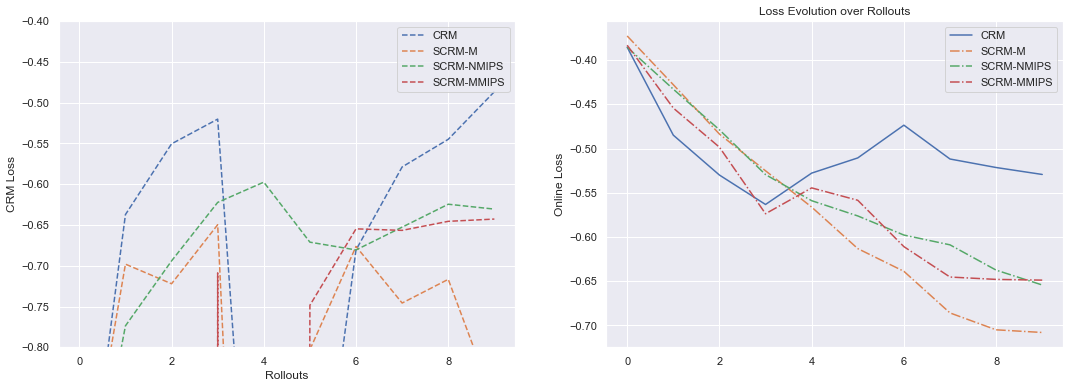

In [49]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
ax.set_ylabel('CRM Loss')
ax.plot(mean_crm_losses, '--', label='CRM')
ax.plot(mean_scrm_m_losses, '--', label='SCRM-M')
ax.plot(mean_scrm_nmips_losses, '--', label='SCRM-NMIPS')
ax.plot(mean_scrm_mmips_losses, '--', label='SCRM-MMIPS')
ax.set_ylim(-0.8, -0.4)
ax.legend(loc='upper right')

ax2.plot(mean_crm_online_losses, '-', label='CRM')
ax2.plot(mean_scrm_m_online_losses, '-.', label='SCRM-M')
ax2.plot(mean_scrm_nmips_online_losses, '-.', label='SCRM-NMIPS')
ax2.plot(mean_scrm_mmips_online_losses,'-.', label='SCRM-MMIPS')
# ax2.plot(batch_kucb_online_losses, label='Batch-KUCB')
# ax2.plot(batch_sbpe_online_losses, label='SBPE')

ax2.set_ylabel('Online Loss')
ax2.legend(loc='upper right')

### SCRM vs CRM

/var/folders/wq/cfl_16c14vg6jh8tsb6vn6zw0000gp/T/ipykernel_7178/1466503038.py:27: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax2.set_yscale('log')


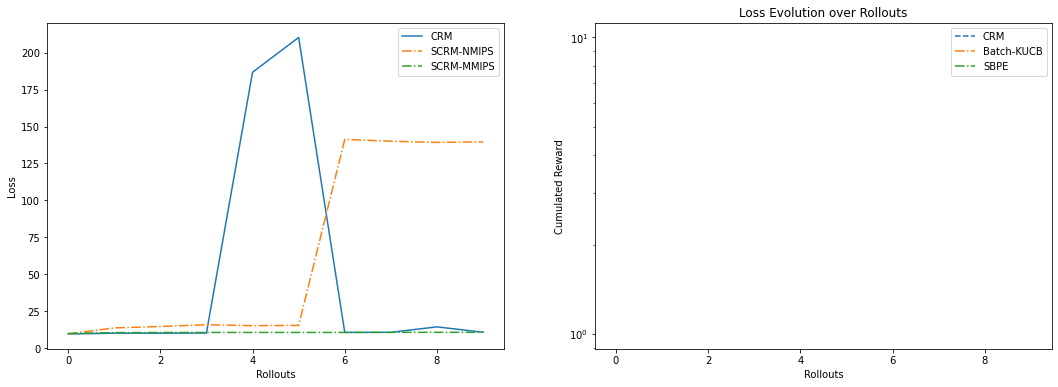

In [39]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
ax.plot(mean_crm_online_losses, '-', label='CRM')
# ax.plot(mean_scrm_m_online_losses, '-.', label='SCRM-M')
ax.plot(mean_scrm_nmips_online_losses, '-.', label='SCRM-NMIPS')
ax.plot(mean_scrm_mmips_online_losses,'-.', label='SCRM-MMIPS')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')

# ax2.set_xlabel('Rollouts')
# ax2.set_ylabel('Regret')
# ax2.plot(mean_crm_regrets, '--', label='CRM')
# ax2.plot(mean_scrm_m_regrets, '--', label='SCRM-M')
# ax2.plot(mean_scrm_nmips_regrets, '--', label='SCRM-NMIPS')
# ax2.plot(mean_scrm_mmips_regrets, '--', label='SCRM-MMIPS')
# ax2.legend(loc='lower right')
# ax2.set_yscale('log')

ax2.set_xlabel('Rollouts')
ax2.set_ylabel('Cumulated Reward')
ax2.plot(-mean_crm_cumulated_losses, '--', label='CRM')
# ax2.plot(-mean_scrm_m_cumulated_losses, '--', label='SCRM-M')
ax2.plot(-mean_scrm_nmips_cumulated_losses, '-.', label='Batch-KUCB')
ax2.plot(-mean_scrm_mmips_cumulated_losses,'-.', label='SBPE')
ax2.legend(loc='upper right')
ax2.set_yscale('log')

# ax2.plot(batch_kucb_online_losses, label='Batch-KUCB')
# ax2.plot(batch_sbpe_online_losses, label='SBPE')


In [292]:
mean_scrm_mmips_online_losses

array([9.12063902, 9.11905974, 9.11792945, 9.11787505, 9.11650278,
       9.11588903, 9.1171697 , 9.11777168, 9.11709129, 9.11773335])

### SCRM vs baselines

NameError: name 'mean_scrm_m_online_losses' is not defined

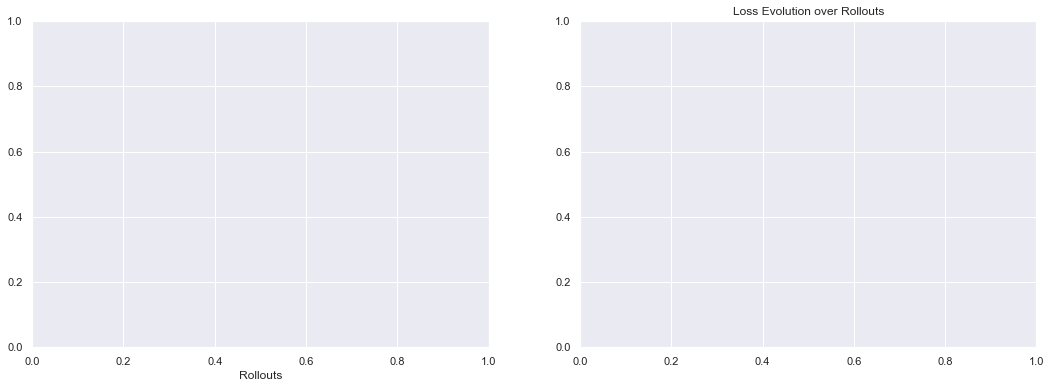

In [16]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(18, 6))
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
# ax.plot(mean_crm_online_losses, '-', label='CRM')
ax.plot(mean_scrm_m_online_losses, '-.', label='SCRM-M')
ax.plot(batch_kucb_online_losses, '-.', label='Batch-KUCB')
ax.plot(batch_sbpe_online_losses,'-.', label='SBPE')
ax.set_ylabel('Loss')
ax.legend(loc='upper right')

ax2.set_xlabel('Rollouts')
ax2.set_ylabel('Cumulated Loss')
# ax2.plot(mean_crm_cumulated_losses, '--', label='CRM')
ax2.plot(mean_scrm_m_cumulated_losses, '--', label='SCRM-M')
ax2.plot(batch_kucb_cumulated_losses, '-.', label='Batch-KUCB')
ax2.plot(batch_sbpe_cumulated_losses,'-.', label='SBPE')
ax2.legend(loc='upper right')


# ax2.plot(batch_kucb_online_losses, label='Batch-KUCB')
# ax2.plot(batch_sbpe_online_losses, label='SBPE')



# Batch bandits

In [4]:
from src.batch_bandits import Polynomial, BatchKernelUCB, SBPE

from tqdm import tqdm

class Environment:

    def __init__(self, dataset, n_logging_samples):
        self.dataset = dataset
        self.n_logging_samples = n_logging_samples

    def sample_data(self, n):
        return self.dataset.sample_data(n_samples=n)

    def sample_reward(self, actions, labels):
        actions = np.squeeze(actions)
        return - self.dataset.get_losses_from_actions(labels, actions)

    def get_anchor_points(self):
        return np.arange(-5, 5, 0.5)
    
    def get_logging_data(self):
        actions, contexts, losses, _, _ = self.dataset.sample_logged_data(self.n_logging_samples)
        return actions, contexts, -losses


def instantiate_metrics():
    return {
        'time': [],
        'online_loss': [],
        'regret': [],
        'cumulated_loss': [],
    }



In [56]:
settings = {
    'agent': 'Batch-KUCB',
    'T': T,
    'random_seed': 42,
    'reg_lambda': 1,
}

n_logging_samples = 10
M = 10

def get_agent(settings, kernel):
    if settings['agent'] == 'Batch-KUCB':
        return BatchKernelUCB(settings, kernel)
    else:
        return SBPE(settings, kernel)

def batch_bandit_experiment(random_seed, dataset_name, settings):
    
    dataset = get_dataset_by_name(dataset_name, random_seed)

    start_experiment(random_seed, dataset, settings['agent'])
    
    # Model setting
    env = Environment(dataset, n_logging_samples)
    kernel = Polynomial(settings)
    agent = get_agent(settings, kernel)
    agent.beta_t = 0.1
    agent.instantiate(env)
    metrics = instantiate_metrics()
    best_strategy_rewards = []

    t0 = time.time()

    batch_size = n_logging_samples
    for step in tqdm(range(M)):

        # choose a random context.
        batch_size *= 2
        contexts, labels = env.sample_data(n=batch_size)
        # iterate learning algorithm for 1 round.
        actions = agent.sample_actions(contexts)
        rewards = env.sample_reward(actions, labels)

        agent.update_agent(contexts, actions, rewards)
        # get best_strategy's reward for the current context.
    #     best_strategy_rewards.append(env.get_best_reward_in_context(context, label))
        t = time.time() - t0
        metrics['time'].append(t)
#         average_reward = np.mean(agent.past_rewards[1:])
        metrics['online_loss'].append(-np.mean(agent.past_rewards[-batch_size:]))
        metrics['cumulated_loss'].append(np.sum(-agent.past_rewards[1:]))
        print('Rollout {}, Online reward: {}'.format(step, -metrics['online_loss'][-1]))

    batch_online_losses = np.array([online_loss._value for online_loss in metrics['online_loss']])
    batch_cumulated_losses = np.array([cumulated_loss._value for cumulated_loss in metrics['cumulated_loss']])
    return np.expand_dims(batch_online_losses, axis=0), np.expand_dims(batch_cumulated_losses, axis=0)


batch_bandit_online_losses = []
batch_bandit_cumulated_losses = []

for random_seed in range(5):
    online_losses, cumulated_losses = batch_bandit_experiment(random_seed, dataset_name, settings)
    batch_bandit_online_losses.append(online_losses)
    batch_bandit_cumulated_losses.append(cumulated_losses)

batch_bandit_online_losses = np.concatenate(batch_bandit_online_losses, axis=0)
batch_kucb_online_losses, batch_k_ucb_online_losses_std = np.mean(batch_bandit_online_losses, axis=0), np.std(batch_bandit_online_losses, axis=0)

batch_bandit_cumulated_losses = np.concatenate(batch_bandit_cumulated_losses, axis=0)
batch_kucb_cumulated_losses, batch_k_ucb_cumulated_losses_std = np.mean(batch_bandit_cumulated_losses, axis=0), np.std(batch_bandit_cumulated_losses, axis=0)

*** EXPERIMENT Batch-KUCB Random seed: 0 Dataset: noisymoons ***
 40%|█████████████████▌                          | 4/10 [00:00<00:00, 15.38it/s]

Rollout 0, Online reward: 0.6001645922660828
Rollout 1, Online reward: 0.4699372947216034
Rollout 2, Online reward: 0.693317711353302
Rollout 3, Online reward: 0.6968349814414978
Rollout 4, Online reward: 0.7173887491226196


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00,  6.78it/s]

Rollout 5, Online reward: 0.7113978266716003
Rollout 6, Online reward: 0.6822718977928162


 80%|███████████████████████████████████▏        | 8/10 [00:08<00:03,  1.67s/it]

Rollout 7, Online reward: 0.6839162111282349


 90%|███████████████████████████████████████▌    | 9/10 [00:56<00:11, 11.71s/it]

Rollout 8, Online reward: 0.5668196678161621


100%|███████████████████████████████████████████| 10/10 [06:59<00:00, 41.95s/it]
*** EXPERIMENT Batch-KUCB Random seed: 1 Dataset: noisymoons ***


Rollout 9, Online reward: -0.022950319573283195


 20%|████████▊                                   | 2/10 [00:00<00:00, 15.28it/s]

Rollout 0, Online reward: 0.6204380989074707
Rollout 1, Online reward: 0.7318664193153381
Rollout 2, Online reward: 0.6358234286308289


 40%|█████████████████▌                          | 4/10 [00:00<00:00, 12.24it/s]

Rollout 3, Online reward: 0.6977288126945496
Rollout 4, Online reward: 0.7297350168228149


 60%|██████████████████████████▍                 | 6/10 [00:00<00:00,  5.46it/s]

Rollout 5, Online reward: 0.7264930605888367


 70%|██████████████████████████████▊             | 7/10 [00:02<00:01,  1.95it/s]

Rollout 6, Online reward: 0.694107174873352


 80%|███████████████████████████████████▏        | 8/10 [00:09<00:04,  2.29s/it]

Rollout 7, Online reward: 0.6625233292579651


 80%|███████████████████████████████████▏        | 8/10 [00:20<00:05,  2.62s/it]


KeyboardInterrupt: 

In [112]:
settings = {
    'agent': 'SBPE',
    'T': T,
    'random_seed': 42,
    'reg_lambda': 1e-5,
}
M = 8

kernel = Polynomial(settings)
agent = SBPE(settings, kernel)

batch_bandit_online_losses = []
batch_bandit_cumulated_losses = []

for random_seed in range(10):
    online_losses, cumulated_losses = batch_bandit_experiment(random_seed, dataset_name, settings)
    batch_bandit_online_losses.append(online_losses)
    batch_bandit_cumulated_losses.append(cumulated_losses)

batch_bandit_online_losses = np.concatenate(batch_bandit_online_losses, axis=0)
batch_sbpe_online_losses, batch_sbpe_online_losses_std = np.mean(batch_bandit_online_losses, axis=0), np.std(batch_bandit_online_losses, axis=0)

batch_bandit_cumulated_losses = np.concatenate(batch_bandit_cumulated_losses, axis=0)
batch_sbpe_cumulated_losses, batch_sbpe_cumulated_losses_std = np.mean(batch_bandit_cumulated_losses, axis=0), np.std(batch_bandit_cumulated_losses, axis=0)


*** EXPERIMENT SBPE Random seed: 0 Dataset: noisymoons ***
 38%|████████████████▉                            | 3/8 [00:00<00:00, 21.81it/s]

Online reward: -0.10000001639127731
Online reward: -0.002117246389389038
Online reward: -0.03949412703514099
Online reward: -0.0455208420753479


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 14.39it/s]

Online reward: 0.17864815890789032
Online reward: 0.05791473388671875
Online reward: -0.02374051697552204


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.15it/s]
*** EXPERIMENT SBPE Random seed: 1 Dataset: noisymoons ***


Online reward: 0.004704478196799755


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 28.67it/s]

Online reward: 0.5890769362449646
Online reward: -0.09999995678663254
Online reward: 0.36050912737846375
Online reward: 0.2396615594625473
Online reward: -0.0856781154870987
Online reward: 0.10798215866088867


 88%|███████████████████████████████████████▍     | 7/8 [00:00<00:00,  6.29it/s]

Online reward: -0.012212378904223442


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.20it/s]
*** EXPERIMENT SBPE Random seed: 2 Dataset: noisymoons ***


Online reward: 0.11916790157556534


 38%|████████████████▉                            | 3/8 [00:00<00:00, 24.31it/s]

Online reward: 0.6623274683952332
Online reward: 0.19819919764995575
Online reward: -0.09526938199996948
Online reward: 0.038844164460897446
Online reward: 0.1624966859817505


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 14.54it/s]

Online reward: 0.11595123261213303
Online reward: 0.07875721901655197


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.16it/s]
*** EXPERIMENT SBPE Random seed: 3 Dataset: noisymoons ***


Online reward: 0.35802802443504333


 38%|████████████████▉                            | 3/8 [00:00<00:00, 29.56it/s]

Online reward: 0.1659092754125595
Online reward: -0.09999995678663254
Online reward: -0.020642369985580444
Online reward: 0.1462685614824295
Online reward: 0.12750661373138428


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 14.41it/s]

Online reward: 0.13772182166576385
Online reward: 0.13042600452899933


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.12it/s]
*** EXPERIMENT SBPE Random seed: 4 Dataset: noisymoons ***


Online reward: 0.06505250185728073


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 29.74it/s]

Online reward: -0.10000001639127731
Online reward: -0.03876375034451485
Online reward: 0.06986036151647568
Online reward: 0.1547996699810028
Online reward: 0.12324482202529907
Online reward: 0.028684867545962334


 88%|███████████████████████████████████████▍     | 7/8 [00:01<00:00,  5.99it/s]

Online reward: -0.09984370321035385


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.15it/s]
*** EXPERIMENT SBPE Random seed: 5 Dataset: noisymoons ***


Online reward: 0.05636269599199295


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 29.24it/s]

Online reward: -0.10000001639127731
Online reward: -0.0362309031188488
Online reward: -0.024480795487761497
Online reward: -0.10000000149011612
Online reward: 0.020688358694314957
Online reward: 0.07448432594537735


 88%|███████████████████████████████████████▍     | 7/8 [00:00<00:00,  6.32it/s]

Online reward: -0.06023517996072769


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.23it/s]
*** EXPERIMENT SBPE Random seed: 6 Dataset: noisymoons ***


Online reward: -0.08624713867902756


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 29.22it/s]

Online reward: -0.04182886704802513
Online reward: -0.015173329971730709
Online reward: 0.061528660356998444
Online reward: 0.04241118207573891
Online reward: -0.07372986525297165
Online reward: -0.024569779634475708


 88%|███████████████████████████████████████▍     | 7/8 [00:01<00:00,  5.90it/s]

Online reward: 0.22030363976955414


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.09it/s]
*** EXPERIMENT SBPE Random seed: 7 Dataset: noisymoons ***


Online reward: -0.037956733256578445


 38%|████████████████▉                            | 3/8 [00:00<00:00, 20.94it/s]

Online reward: 0.34365710616111755
Online reward: 0.3178836703300476
Online reward: 0.1772085279226303
Online reward: 0.010790384374558926
Online reward: -0.028677960857748985


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 12.74it/s]

Online reward: -0.09016434103250504
Online reward: -0.014382228255271912


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.04it/s]
*** EXPERIMENT SBPE Random seed: 8 Dataset: noisymoons ***


Online reward: -0.09996749460697174


 38%|████████████████▉                            | 3/8 [00:00<00:00, 27.22it/s]

Online reward: -0.10000001639127731
Online reward: -0.04052574560046196
Online reward: 0.3592087924480438
Online reward: -0.0069081285037100315
Online reward: -0.023232141509652138


 75%|█████████████████████████████████▊           | 6/8 [00:00<00:00, 14.14it/s]

Online reward: -0.08291703462600708
Online reward: 0.05511239171028137


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.02it/s]
*** EXPERIMENT SBPE Random seed: 9 Dataset: noisymoons ***


Online reward: 0.02018297091126442


 50%|██████████████████████▌                      | 4/8 [00:00<00:00, 29.56it/s]

Online reward: -0.05215660482645035
Online reward: 0.1608698070049286
Online reward: 0.09204912930727005
Online reward: 0.0027879048138856888
Online reward: -0.04128950461745262
Online reward: -0.10000001639127731


 88%|███████████████████████████████████████▍     | 7/8 [00:00<00:00,  6.12it/s]

Online reward: 0.05928536877036095


100%|█████████████████████████████████████████████| 8/8 [00:03<00:00,  2.11it/s]

Online reward: 0.1083894744515419


In [99]:
batch_sbpe_online_losses

array([-0.42547998, -0.6544496 , -0.6454035 , -0.6929121 , -0.71240985,
       -0.7120695 , -0.724742  , -0.72789574], dtype=float32)

In [63]:
array[-5:]

array([95, 96, 97, 98, 99])

In [92]:
batch_kucb_online_losses

array([-0.4058508 , -0.52489346, -0.5379437 , -0.48313928, -0.43111897,
       -0.3787202 , -0.30418026, -0.26423642], dtype=float32)